In [0]:
import warnings
warnings.filterwarnings('ignore')

!pip install -q keras

import os
import pandas as pd
import numpy as np

from google.colab import files

from sklearn.utils import shuffle
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
from pylab import rcParams

### 上傳 `pkgo_norm.csv` 上傳到 colab

In [0]:
if not os.path.exists('pkgo_nyc_5class.csv.bz2'):
    uploaded = files.upload()

### 讀取 `pkgo_norm.csv`

In [0]:
pkgo = pd.read_csv('pkgo_nyc_5class.csv.bz2')

### 建構模型

In [0]:
''' Import keras to build a DL model '''
from keras.models import Model, Sequential
from keras.layers import Dense, Activation, LeakyReLU
from keras.optimizers import SGD, RMSprop, Adam
''' Import l1,l2 (regularizer) '''
from keras.regularizers import l1, l2, l1_l2

def build_model(X, l1_alpha, l2_alpha):
    model = Sequential()
    model.add(Dense(128, input_dim=X.shape[-1], kernel_regularizer=l1_l2(l1=l1_alpha, l2=l2_alpha)))
    model.add(Activation('relu'))
    model.add(Dense(256, kernel_regularizer=l1_l2(l1=l1_alpha, l2=l2_alpha)))
    model.add(Activation('relu'))
    model.add(Dense(5, kernel_regularizer=l1_l2(l1=l1_alpha, l2=l2_alpha)))
    model.add(Activation('softmax'))
    return model

In [0]:
def Xy_split(pkgo):
    num_cols = pkgo.shape[1]
    X = pkgo.iloc[:, :num_cols-1]
    y = pkgo['class']
    
    # 型別轉換，確保資料型態正確
    X = X.astype(np.float32)
    y = y.astype(np.int)
    
    # 對 y 做 one-hot encoding
    y = to_categorical(y)
    
    # 打亂資料集
    X, y = shuffle(X, y)
    
    return X, y

X, y = Xy_split(pkgo)

## 比較不同 regularizer 對訓練結果之差異

In [22]:
import keras.backend as K

l1_l2_list = [(0, 0), (5e-4, 0), (0, 5e-3), (0, 5e-4), (0, 5e-5)]

train_loss_list = []
train_acc_list = []

valid_loss_list = []
valid_acc_list = []

for l1_alpha, l2_alpha in l1_l2_list:
    K.clear_session()
    
    early_stopping = EarlyStopping(monitor = 'val_loss', 
                                   patience = 5, 
                                   verbose = 1)
    
    print('Building a model with regularizer L1: {}, L2: {}'.format(l1_alpha, l2_alpha))
    
    model = build_model(X, l1_alpha, l2_alpha)
    
    optim = Adam(lr=5e-5)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optim,
                  metrics=['accuracy'])

    batch_size=32
    epochs = 200

    history = model.fit(X, y,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        shuffle=True,
                        validation_split=0.1,
                        callbacks=[early_stopping])
    
    loss = history.history.get('loss')
    acc = history.history.get('acc')
    val_loss = history.history.get('val_loss')
    val_acc = history.history.get('val_acc')

    train_loss_list.append(loss)
    valid_loss_list.append(val_loss)
    train_acc_list.append(acc)
    valid_acc_list.append(val_acc)

Building a model with regularizer L1: 0, L2: 0
Epoch 00058: early stopping
Building a model with regularizer L1: 0.0005, L2: 0
Epoch 00067: early stopping
Building a model with regularizer L1: 0, L2: 0.005
Epoch 00076: early stopping
Building a model with regularizer L1: 0, L2: 0.0005
Epoch 00066: early stopping
Building a model with regularizer L1: 0, L2: 5e-05
Epoch 00067: early stopping


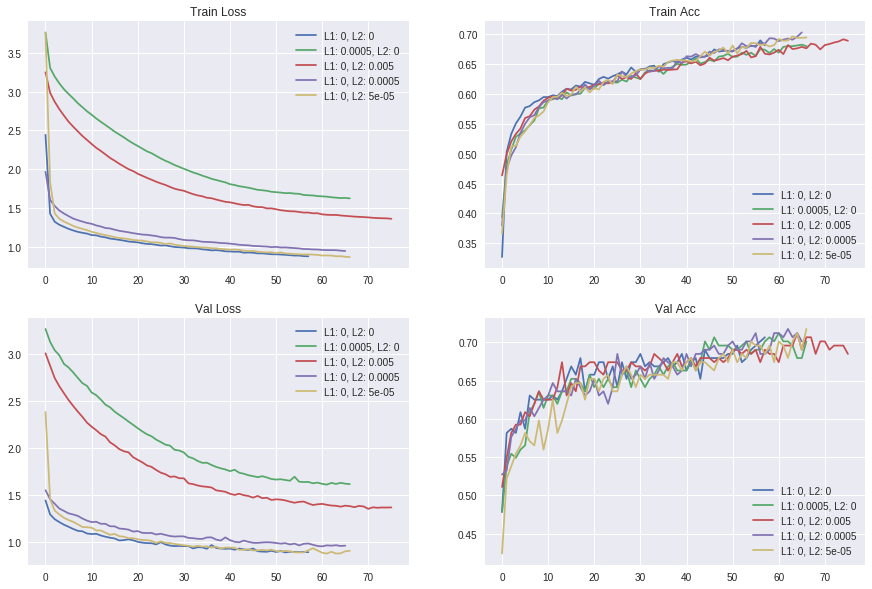

In [23]:
''' Visualize the training/validation loss and training/validation accuracy'''
rcParams['figure.figsize'] = 15, 10
    
plt.figure(0)

# Training Loss
plt.subplot(221)
for k in range(len(l1_l2_list)):
    label_l1 = l1_l2_list[k][0]
    label_l2 = l1_l2_list[k][1]
    train_label = 'L1: {}, L2: {}'.format(label_l1, label_l2)
    loss = train_loss_list[k]
    plt.plot(range(len(loss)), loss, label=train_label)
    plt.legend(loc='best')
    plt.title('Train Loss')

# Training Accuracy
plt.subplot(222)
for k in range(len(l1_l2_list)):
    label_l1 = l1_l2_list[k][0]
    label_l2 = l1_l2_list[k][1]
    train_label = 'L1: {}, L2: {}'.format(label_l1, label_l2)
    acc = train_acc_list[k]
    plt.plot(range(len(acc)), acc, label=train_label)
    plt.legend(loc='best')
    plt.title('Train Acc')

# Validation Loss
plt.subplot(223)
for k in range(len(l1_l2_list)):
    label_l1 = l1_l2_list[k][0]
    label_l2 = l1_l2_list[k][1]
    val_label = 'L1: {}, L2: {}'.format(label_l1, label_l2)
    val_loss = valid_loss_list[k]
    plt.plot(range(len(val_loss)), val_loss, label=val_label)
    plt.legend(loc='best')
    plt.title('Val Loss')

# Validation Accuracy
plt.subplot(224)
for k in range(len(l1_l2_list)):
    label_l1 = l1_l2_list[k][0]
    label_l2 = l1_l2_list[k][1]
    val_label = 'L1: {}, L2: {}'.format(label_l1, label_l2)
    val_acc = valid_acc_list[k]
    plt.plot(range(len(val_acc)), val_acc, label=val_label)
    plt.legend(loc='best')
    plt.title('Val Acc')
    
plt.show()

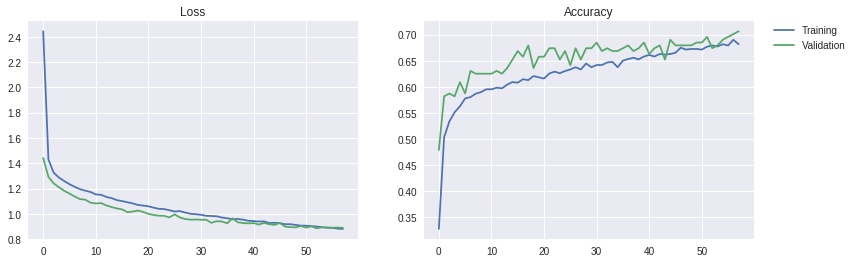

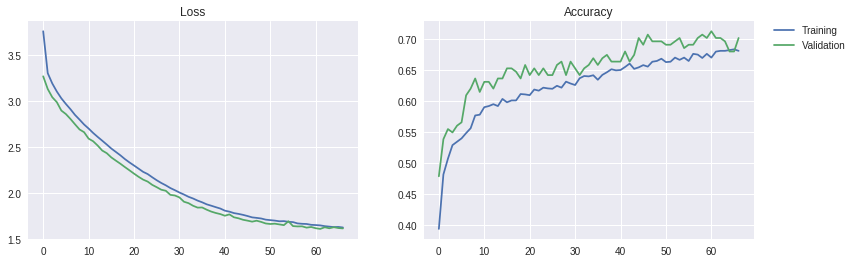

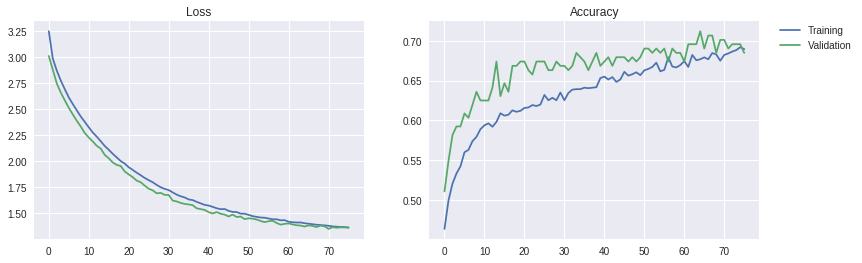

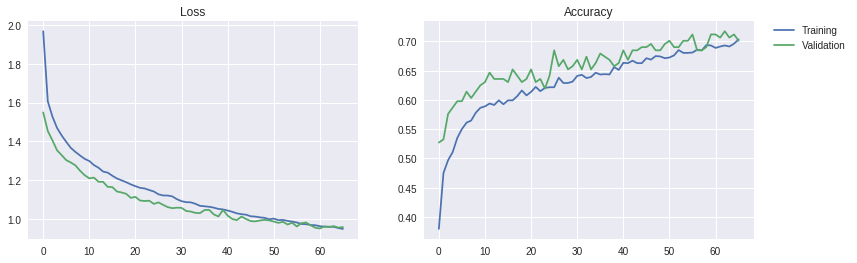

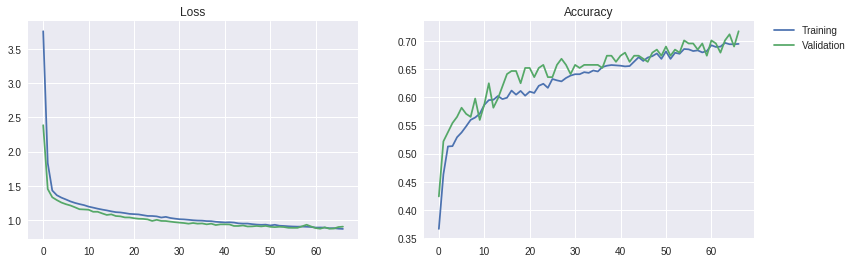

In [24]:
''' Visualize the training/validation loss and training/validation accuracy'''
rcParams['figure.figsize'] = 13, 4
    

for k in range(len(l1_l2_list)):
    plt.figure(0)
    
    plt.subplot(121)
    label_l1 = l1_l2_list[k][0]
    label_l2 = l1_l2_list[k][1]
    loss = train_loss_list[k]
    val_loss = valid_loss_list[k]
    plt.plot(range(len(loss)), loss, label='Training')
    plt.plot(range(len(val_loss)), val_loss, label='Validation')
    plt.title('Loss')
    
    plt.subplot(122)
    label_l1 = l1_l2_list[k][0]
    label_l2 = l1_l2_list[k][1]
    val_label = 'L1, L2: {}, {}'.format(label_l1, label_l2)
    acc = train_acc_list[k]
    val_acc = valid_acc_list[k]
    plt.plot(range(len(acc)), acc, label='Training')
    plt.plot(range(len(val_acc)), val_acc, label='Validation')
    plt.title('Accuracy')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

    plt.show()